In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices("GPU")))

2025-06-21 09:53:50.440806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: Th

TensorFlow version: 2.16.1
Num GPUs Available: 1


In [3]:
# Import required libraries
import numpy as np
from pathlib import Path
import gc
import time
import psutil
import multiprocessing
import concurrent.futures
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import os
import warnings


# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Global configuration
INPUT_SHAPE = (128, 128, 128, 1)
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCHS = 200
VALIDATION_SPLIT = 0.2

# Basic GPU configuration (handles CUDA compatibility issues)
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"✅ GPU configured: {len(gpus)} device(s) found")
    else:
        print("⚠️  No GPU found - using CPU")
except Exception as e:
    print(f"⚠️  GPU setup failed: {e} - using CPU fallback")

print("✅ Environment setup complete")
print(f"📊 Configuration: {INPUT_SHAPE[:-1]} input, batch_size={BATCH_SIZE}, epochs={EPOCHS}")

✅ GPU configured: 1 device(s) found
✅ Environment setup complete
📊 Configuration: (128, 128, 128) input, batch_size=8, epochs=200


In [4]:
def load_volume_cpu(file_path, target_shape=(128, 128, 128)):
    """Compact CPU-only volume loader."""
    try:
        with np.load(file_path) as data:
            # Get volume data
            volume = data['data'] if 'data' in data else data[list(data.keys())[0]]
            
            # Resize using scipy
            zoom_factors = [target_shape[i] / volume.shape[i] for i in range(3)]
            volume = zoom(volume, zoom_factors, order=1)
            
            # Normalize
            volume = (volume - volume.min()) / (volume.max() - volume.min() + 1e-8)
            return volume.astype(np.float32)
    except Exception as e:
        print(f"❌ Failed: {file_path.name}")
        return None

def load_dataset_cpu(num_samples=None):
    """Load dataset using CPU-only processing."""
    print("🖥️  Loading dataset with CPU-only processing...")
    
    # Paths
    
    raw_dir = Path('/mnt/home/dchhantyal/centroid_model_blastospim/data/raw/')
    labels_dir = Path('/mnt/home/dchhantyal/centroid_model_blastospim/data/labels/Blast')
    
    # Get data files from all subdirectories
    data_files = sorted(list(raw_dir.rglob('*.npz')))
    if num_samples:
        data_files = data_files[:num_samples]
    
    print(f"📦 Processing {len(data_files)} files...")
    
    volumes, centroids = [], []
    
    # Process with threading for I/O
    def process_file(file_path):
        volume = load_volume_cpu(file_path)
        if volume is None:
            return None, None
            
        # Load corresponding label
        label_file = labels_dir / f"label_{file_path.stem}" / "data" / "label.npz"
        try:
            with np.load(label_file) as label_data:
                centroid = label_data['centroid']
                # Normalize centroid [0,1]
                norm_centroid = np.array([
                    centroid[0] / 101.0,
                    centroid[1] / 2048.0, 
                    centroid[2] / 2048.0
                ], dtype=np.float32)
                return volume, norm_centroid
        except:
            return None, None
    
    # Parallel processing
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(process_file, data_files))
    
    # Collect successful results
    for volume, centroid in results:
        if volume is not None:
            volumes.append(volume)
            centroids.append(centroid)
    
    print(f"✅ Loaded {len(volumes)} samples successfully")
    return np.array(volumes), np.array(centroids)

In [5]:
# Load Dataset with CPU-only processing (CUDA compatibility issues resolved)
print("🚀 Loading dataset...")
start_time = time.time()

# Load data using CPU-only method
X, y = load_dataset_cpu(num_samples=None)

# Add channel dimension for CNN
X = X[..., np.newaxis]

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VALIDATION_SPLIT, random_state=RANDOM_SEED
)

loading_time = time.time() - start_time

print(f"✅ Dataset loaded successfully!")
print(f"📊 Training set: {X_train.shape}, {y_train.shape}")
print(f"📊 Validation set: {X_val.shape}, {y_val.shape}")
print(f"⏱️  Loading time: {loading_time:.2f} seconds")
print(f"💾 Memory usage: {(X.nbytes + y.nbytes) / (1024**3):.2f} GB")

🚀 Loading dataset...
🖥️  Loading dataset with CPU-only processing...
📦 Processing 1131 files...
✅ Loaded 1131 samples successfully
✅ Dataset loaded successfully!
📊 Training set: (904, 128, 128, 128, 1), (904, 3)
📊 Validation set: (227, 128, 128, 128, 1), (227, 3)
⏱️  Loading time: 284.49 seconds
💾 Memory usage: 8.84 GB


In [6]:
X.shape, y.shape

((1131, 128, 128, 128, 1), (1131, 3))

In [7]:
# Build 3D CNN Model for Centroid Regression
def create_3d_cnn_model(input_shape=(128, 128, 128, 1)):
    """Create a 3D CNN model for centroid regression."""
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First 3D conv block
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        # Second 3D conv block  
        tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        # Third 3D conv block
        tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        # Global average pooling instead of flatten to reduce parameters
        tf.keras.layers.GlobalAveragePooling3D(),
        
        # Dense layers for regression
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        
        # Output layer (3 coordinates: x, y, z)
        tf.keras.layers.Dense(3, activation='sigmoid')  # Normalized coordinates [0,1]
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create and display model
model = create_3d_cnn_model()
model.summary()

print(f"✅ 3D CNN model created successfully")
print(f"📊 Total parameters: {model.count_params():,}")

2025-06-21 09:59:03.373804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1c:00.0, compute capability: 7.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 128, 128, 128,  │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 64, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 64, 64, 64, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 32, 32, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 32, 32, 32,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 16, 16, 16,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 16,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 344,771 (1.32 MB)

 Trainable params: 344,323 (1.31 MB)

 Non-trainable params: 448 (1.75 KB)

✅ 3D CNN model created successfully
📊 Total parameters: 344,771


In [8]:
# Train the Model
print("🚀 Starting model training...")

# Setup callbacks
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"3d_cnn_blast_v2{timestamp}"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f'models/checkpoints/{model_name}_best.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training completed!")

🚀 Starting model training...
Epoch 1/200


I0000 00:00:1750514355.506719 1055817 service.cc:145] XLA service 0x1552000137b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750514355.506833 1055817 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-06-21 09:59:15.616934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-21 09:59:15.988599: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-06-21 09:59:23.230655: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=0,k3=0} for conv (f32[32,1,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,1,128,128,128]{4,3,2,1,0}, f32[8,32,128,128,128]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_

  1/113 ━━━━━━━━━━━━━━━━━━━━ 30:09 16s/step - loss: 0.0901 - mae: 0.2397

I0000 00:00:1750514369.146519 1055817 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0251 - mae: 0.1190
Epoch 1: val_loss improved from inf to 0.00512, saving model to models/checkpoints/3d_cnn_blast_v220250621_095903_best.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - loss: 0.0250 - mae: 0.1188 - val_loss: 0.0051 - val_mae: 0.0508 - learning_rate: 0.0010
Epoch 2/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0104 - mae: 0.0805
Epoch 2: val_loss improved from 0.00512 to 0.00445, saving model to models/checkpoints/3d_cnn_blast_v220250621_095903_best.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - loss: 0.0104 - mae: 0.0804 - val_loss: 0.0045 - val_mae: 0.0431 - learning_rate: 0.0010
Epoch 3/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0077 - mae: 0.0685
Epoch 3: val_loss did not improve from 0.00445
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - loss: 0.0077 - mae: 0.0685 - val_loss: 0.0051 - val_mae: 0.0470 - learning_rate: 0.0010
Epoch 4/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - 

In [9]:

# Save final model
model.save(f'models/v2_{model_name}_final.h5')
model.save(f'models/v2_{model_name}_final.keras')

print(f"✅ Model saved as {model_name}_final.h5")
print(f"📊 Training completed successfully!")

✅ Model saved as 3d_cnn_blast_v220250621_095903_final.h5
📊 Training completed successfully!


📊 Evaluating model performance...
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step
📈 Validation Metrics:
   Mean Absolute Error: 0.0309
   Mean Squared Error: 0.0018
   Root Mean Squared Error: 0.0426


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/home/dchhantyal/centroid_model_blastospim/notebooks/visualizations/3d_cnn_blast_v220250621_095903_training_history.png'

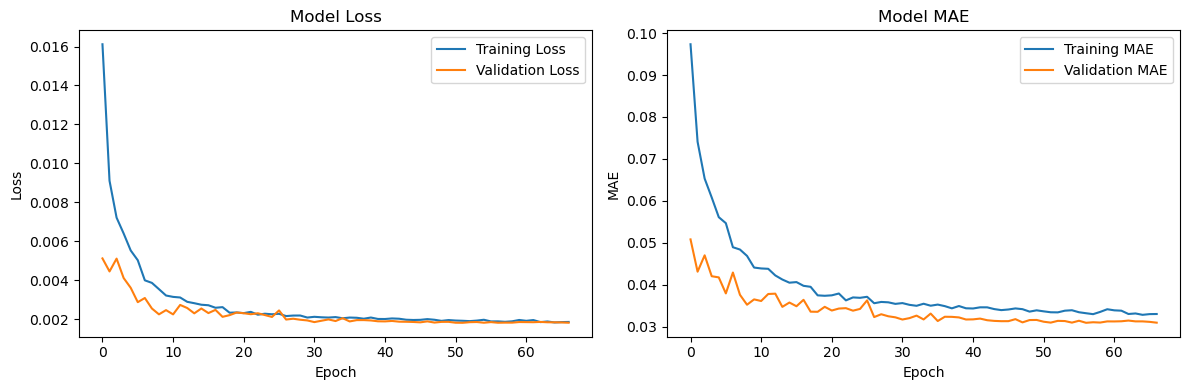

In [10]:
# Evaluate Model and Save Results
print("📊 Evaluating model performance...")

# Make predictions
y_pred = model.predict(X_val, batch_size=4)

# Calculate metrics
mae = np.mean(np.abs(y_val - y_pred))
mse = np.mean((y_val - y_pred) ** 2)
rmse = np.sqrt(mse)

print(f"📈 Validation Metrics:")
print(f"   Mean Absolute Error: {mae:.4f}")
print(f"   Mean Squared Error: {mse:.4f}")
print(f"   Root Mean Squared Error: {rmse:.4f}")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# MAE plot
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()

plt.tight_layout()
plt.savefig(f'visualizations/{model_name}_training_history.png', dpi=300, bbox_inches='tight')
plt.show()
